In [111]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [112]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

In [115]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets

# Define transformations for data augmentation for training data only
transform_train = transforms.Compose([
    transforms.RandomRotation(15),             # Randomly rotate the image by up to 15 degrees
    transforms.RandomHorizontalFlip(),         # Randomly flip the image horizontally
    transforms.RandomCrop(size=28, padding=4), # Randomly crop the image with padding of 4 pixels
    transforms.ToTensor(),                     # Convert the image to tensor
])

# Define transformation for validation and test set (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Mount Google Drive
drive.mount('/content/drive')

# Load the .npz file from Google Drive
data = np.load('/content/drive/MyDrive/imbalanced_mnist.npz')

# Extract the arrays from the loaded data
X_train = data['X_train.npy']
X_test = data['X_test.npy']
y_train = data['y_train.npy']
y_test = data['y_test.npy']

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

# Create datasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Apply transformations only to the training dataset
train_dataset.transform = transform_train

# Get the indices of samples in the dataset
indices = list(range(len(test_dataset)))

# Split the indices into validation and testing sets
val_indices, test_indices = train_test_split(indices, test_size=0.5, random_state=42)



#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)  # MMMR --- Shuffle needs to be true.

# Create DataLoader for validation set
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=val_sampler)

# Create DataLoader for testing set
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset[0]

(tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            3, 121, 202, 243,  95,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,
          173, 212,  45,  31,  41,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7, 145,
          212,  22,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

# Define your neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define grid of hyperparameters to tune
param_grid = {
    'hidden_size1': [128, 256, 512],
    'hidden_size2': [64, 128, 256],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Define other training parameters
input_size = 28 * 28  # Size of input features
output_size = 10      # Number of classes
batch_size = 32
epochs = 10

# Prepare data loaders
# Make sure to run the previous code to define train_loader, validation_loader, and test_loader

best_accuracy = 0
best_params = None

# Iterate over parameter grid
for params in ParameterGrid(param_grid):
    # Initialize model
    model = NeuralNetwork(input_size, params['hidden_size1'], params['hidden_size2'], output_size)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])


    # Train the model
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.float()  # Convert input data to float32
            outputs = model(inputs.view(inputs.size(0), -1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.float()  # Convert input data to float32
                outputs = model(inputs.view(inputs.size(0), -1))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Epoch {epoch+1}/{epochs}, Validation Accuracy: {accuracy}')

    # Check if this model is the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f'Best validation accuracy: {best_accuracy}')
print(f'Best hyperparameters: {best_params}')


Epoch 1/10, Validation Accuracy: 0.9434
Epoch 2/10, Validation Accuracy: 0.9614
Epoch 3/10, Validation Accuracy: 0.9626
Epoch 4/10, Validation Accuracy: 0.964
Epoch 5/10, Validation Accuracy: 0.9656
Epoch 6/10, Validation Accuracy: 0.9644
Epoch 7/10, Validation Accuracy: 0.9704
Epoch 8/10, Validation Accuracy: 0.9708
Epoch 9/10, Validation Accuracy: 0.9754
Epoch 10/10, Validation Accuracy: 0.9632
Epoch 1/10, Validation Accuracy: 0.5836
Epoch 2/10, Validation Accuracy: 0.9032
Epoch 3/10, Validation Accuracy: 0.927
Epoch 4/10, Validation Accuracy: 0.9254
Epoch 5/10, Validation Accuracy: 0.9336
Epoch 6/10, Validation Accuracy: 0.9358
Epoch 7/10, Validation Accuracy: 0.936
Epoch 8/10, Validation Accuracy: 0.924
Epoch 9/10, Validation Accuracy: 0.94
Epoch 10/10, Validation Accuracy: 0.9272
Epoch 1/10, Validation Accuracy: 0.0986
Epoch 2/10, Validation Accuracy: 0.1014
Epoch 3/10, Validation Accuracy: 0.1158
Epoch 4/10, Validation Accuracy: 0.1158
Epoch 5/10, Validation Accuracy: 0.1158
Epoc

In [ ]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, random_split

# # Define transformations for data augmentation for training data only
# transform_train = transforms.Compose([
#     transforms.RandomRotation(15),             # Randomly rotate the image by up to 15 degrees
#     transforms.RandomHorizontalFlip(),         # Randomly flip the image horizontally
#     transforms.RandomCrop(size=28, padding=4), # Randomly crop the image with padding of 4 pixels
#     transforms.ToTensor(),                     # Convert the image to tensor
# ])

# # Define transformation for validation and test set (no augmentation)
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
# ])

# # Load the MNIST dataset
# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# # Split the training data into training and validation sets
# train_size = int(0.8 * len(mnist_train))
# valid_size = len(mnist_train) - train_size
# train_dataset, valid_dataset = random_split(mnist_train, [train_size, valid_size])

# # Define batch sizes for data loaders
# batch_size_train = 64
# batch_size_valid = 64
# batch_size_test = 64

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)
# test_loader = DataLoader(mnist_test, batch_size=batch_size_test, shuffle=False)


In [118]:
best_params

Epoch 1/10, Training Loss: 0.6227228971790771, Validation Loss: 0.14537998169660568
Epoch 2/10, Training Loss: 0.25342023710577916, Validation Loss: 0.11486055736541748
Epoch 3/10, Training Loss: 0.19238864486130733, Validation Loss: 0.09786209877002984
Epoch 4/10, Training Loss: 0.15856542258126133, Validation Loss: 0.08660773202627897
Epoch 5/10, Training Loss: 0.1361188758124512, Validation Loss: 0.0870899155177176
Epoch 6/10, Training Loss: 0.11956024805732772, Validation Loss: 0.07938651231564581
Epoch 7/10, Training Loss: 0.1061837030902669, Validation Loss: 0.0747847914300859
Epoch 8/10, Training Loss: 0.09561905857030675, Validation Loss: 0.07477521705627442
Epoch 9/10, Training Loss: 0.0871016761610491, Validation Loss: 0.07039058756828308
Epoch 10/10, Training Loss: 0.07891333179328969, Validation Loss: 0.06888890554830432
Test Loss: 0.07287756333239377, Test Accuracy: 0.9574


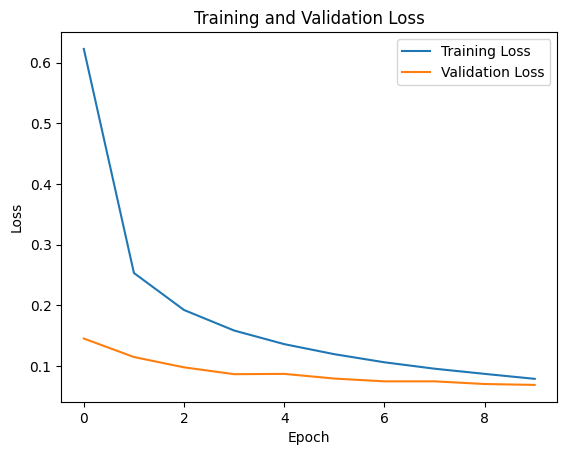

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define your neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define hyperparameters
input_size = 28 * 28  # Size of input features
output_size = 10      # Number of classes
hidden_size1 = best_params['hidden_size1']    # Size of the first hidden layer
hidden_size2 = best_params['hidden_size2']    # Size of the second hidden layer
learning_rate = best_params['learning_rate']  # Learning rate
batch_size = 32       # Batch size
epochs = 10           # Number of epochs

# Initialize the model
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store training and validation loss
train_losses = []
valid_losses = []

# Train the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the input images
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.float()
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the input images
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    # Print progress
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {valid_loss}')

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.float()
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the input images
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
!pip install flopth torchmetrics

In [ ]:
!pip install flopth

In [88]:
!pip install torchprofile


In [133]:
from torchprofile import profile_macs
import torch

# Assuming you have your model defined and named `model`

# Count number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params)

# Profile FLOPs
inputs = torch.randn(1, 784)  # Example input tensor with appropriate dimensions
flops_torch = profile_macs(model, inputs)
print("FLOPs:", flops_torch)


Number of parameters: 214538


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 784]

In [130]:
from flopth import flopth
flops, params = flopth(model, in_size=(784,),show_detail=True)
print(flops, params)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 784]

In [124]:
from torchmetrics import ConfusionMatrix, Precision, Recall
confusion_matrix = ConfusionMatrix(num_classes=10,task="multiclass")
precision = Precision(num_classes=10,task="multiclass")
recall = Recall(num_classes=10,task="multiclass")

with torch.no_grad():
    for images, labels in test_loader:
        # Move input data to GPU if available
        outputs = model(images.float().view(-1, 784))
        pred = torch.argmax(outputs, dim=1)
        confusion_matrix.update(pred, labels)
        precision.update(pred, labels)
        recall.update(pred, labels)


# Compute and print metrics
print("Confusion Matrix:")
print(confusion_matrix.compute().numpy())

print("Precision:")
print(precision.compute())

print("Recall:")
print(recall.compute())

Confusion Matrix:
[[483   0   2   0   1   2   3   0   2   1]
 [  0 551   1   1   0   0   1   1   6   0]
 [  7   2 495   4   6   0   1   3   5   1]
 [  0   0   3 499   0  13   1   3   2   2]
 [  0   0   3   0 482   0   2   1   3  10]
 [  0   0   0   7   1 399   3   0   3   2]
 [  6   1   2   0   7   1 475   1   1   0]
 [  1   3   7   1   3   1   0 468   0  12]
 [  1   0   2   5   4   5   2   4 454   3]
 [  1   3   1   7  11   2   0   2   4 481]]
Precision:
tensor(0.9574)
Recall:
tensor(0.9574)


In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics import Accuracy
from sklearn.model_selection import ParameterGrid


In [126]:
class CNN(nn.Module):
    def __init__(self, nconv1=16, nconv2=32):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, nconv1, 3, padding='same')
        self.conv2 = nn.Conv2d(nconv1, nconv2, 3, padding='same')
        self.nn1 = nn.Linear(nconv2 * 7 * 7, 128)
        self.nn2 = nn.Linear(128, 64)
        self.nn3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.nn1(x))
        x = F.relu(self.nn2(x))
        x = self.nn3(x)
        return x


In [128]:


best_accuracy = 0
best_params = None

cnn_param_grid = {
    'nconv1': [16, 32, 64],
    'nconv2': [32, 64, 128],
    'lr': [0.001, 0.01, 0.1]
}

for params in ParameterGrid(cnn_param_grid):
    # Initialize model with current hyperparameters
    model = CNN(params['nconv1'], params['nconv2'])

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    # Define accuracy metric
    accuracy = Accuracy()

    # Train the model
    for epoch in range(10):
        model.train()
        running_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output = model(inputs.unsqueeze(1).float())
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in validation_loader:
                output = model(data.unsqueeze(1).float())
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        # Calculate accuracy using torchmetrics
        val_accuracy = correct / total

        # Print current hyperparameters and validation accuracy
        print(f'Params: {params}, Epoch[{epoch+1}/10], Val_accuracy: {val_accuracy:.3f}')

        # Update best accuracy and best parameters
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)


TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'